In [1]:
!pip install tensorflow==2.10.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 72.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 74.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 31.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorf

In [2]:
from keras.layers import Reshape

2024-04-28 14:39:02.557553: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl7strings6StrCatB5cxx11ERKNS0_8AlphaNumES3_']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libt

In [13]:
import os
import numpy as np
import json
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, Dropout, TimeDistributed


# Set the directory path where your JSON file is located
DATA_DIRECTORY = "/kaggle/input/audio-for-lstm"

# Define the filename of your JSON file
DATA_FILENAME = "data.json"

# Construct the full path to your JSON file
DATA_PATH = os.path.join(DATA_DIRECTORY, DATA_FILENAME)


# Load data
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

# Prepare datasets
def prepare_datasets(test_size, validation_size):
    X, y = load_data(DATA_PATH)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    return X_train, X_validation, X_test, y_train, y_validation, y_test

def build_hybrid_model(input_shape, num_classes):
    model = Sequential()

    # CNN layers
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())

    # Reshape data for LSTM
    num_timesteps = input_shape[0] // 8  # Assuming 8 features per timestep
    model.add(Reshape((num_timesteps, -1)))  # Reshape to (num_timesteps, num_features_per_timestep)

    # LSTM layer
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))

    # Flatten LSTM output
    model.add(Flatten())

    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model


if __name__ == "__main__":
    # Parameters
    TEST_SIZE = 0.2
    VALIDATION_SIZE = 0.1
    
    # Load and prepare datasets
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(TEST_SIZE, VALIDATION_SIZE)
    
    NUM_CLASSES = 10  # Number of classes in your dataset
    INPUT_SHAPE = (X_train.shape[1], X_train.shape[2], 1)  # Adjust input shape based on your data

    # Load and prepare datasets
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(TEST_SIZE, VALIDATION_SIZE)

    # Build hybrid model
    model = build_hybrid_model(INPUT_SHAPE, NUM_CLASSES)

    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

    # Evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print('\nTest accuracy:', test_acc)

Epoch 1/50
29/29 [==============================] - 5s 81ms/step - loss: 0.9742 - accuracy: 0.5156 - val_loss: 0.6074 - val_accuracy: 0.6900
Epoch 2/50
29/29 [==============================] - 2s 57ms/step - loss: 0.7111 - accuracy: 0.5646 - val_loss: 0.5924 - val_accuracy: 0.7400
Epoch 3/50
29/29 [==============================] - 2s 68ms/step - loss: 0.6671 - accuracy: 0.6114 - val_loss: 0.5323 - val_accuracy: 0.7400
Epoch 4/50
29/29 [==============================] - 2s 61ms/step - loss: 0.6360 - accuracy: 0.6437 - val_loss: 0.4721 - val_accuracy: 0.8000
Epoch 5/50
29/29 [==============================] - 2s 57ms/step - loss: 0.5725 - accuracy: 0.7049 - val_loss: 0.4318 - val_accuracy: 0.8200
Epoch 6/50
29/29 [==============================] - 2s 58ms/step - loss: 0.5088 - accuracy: 0.7684 - val_loss: 0.3610 - val_accuracy: 0.8500
Epoch 7/50
29/29 [==============================] - 2s 58ms/step - loss: 0.4304 - accuracy: 0.8140 - val_loss: 0.4178 - val_accuracy: 0.8400
Epoch 8/50
29

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import classification_report

8/8 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       124
           1       0.92      0.93      0.92       126

    accuracy                           0.92       250
   macro avg       0.92      0.92      0.92       250
weighted avg       0.92      0.92      0.92       250

29/29 [==============================] - 0s 15ms/step - loss: 0.1581 - accuracy: 0.9376


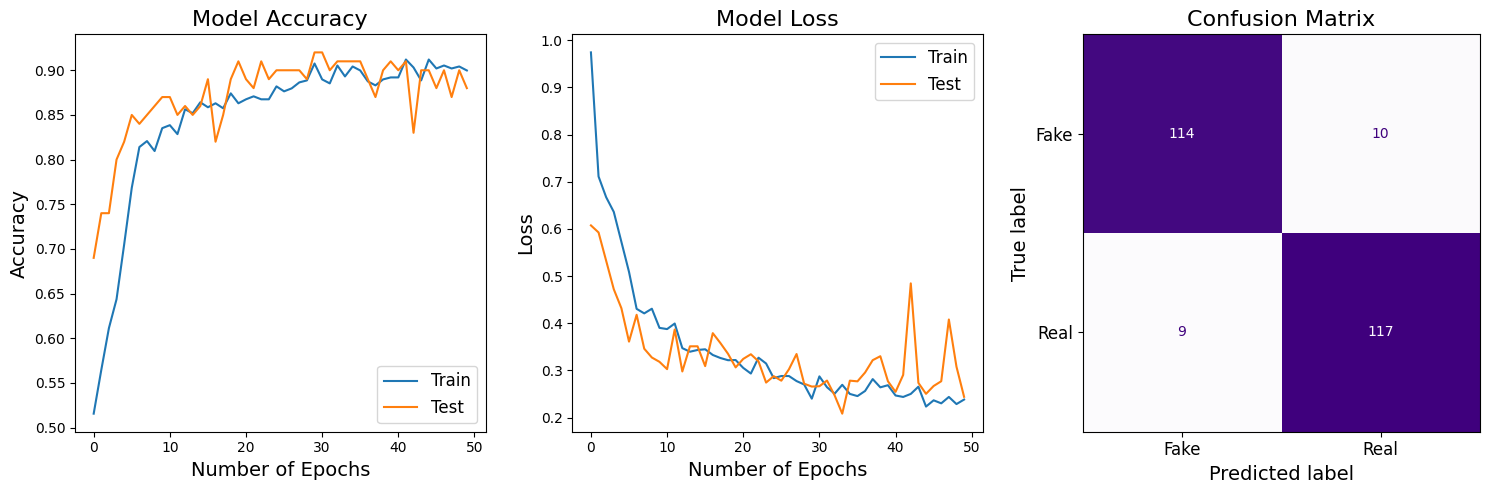

In [14]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import classification_report

# Create subplots for accuracy, loss, and confusion matrix
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  

# Plot accuracy
axs[0].plot(history.history["accuracy"], label="Train")
axs[0].plot(history.history["val_accuracy"], label="Test")
axs[0].set_ylabel("Accuracy",fontsize=14)
axs[0].set_xlabel("Number of Epochs",fontsize=14)
axs[0].legend(loc="lower right",fontsize=12)
axs[0].set_title("Model Accuracy", fontsize=16)

# Plot loss
axs[1].plot(history.history["loss"], label="Train")
axs[1].plot(history.history["val_loss"], label="Test")
axs[1].set_ylabel("Loss", fontsize=14)
axs[1].set_xlabel("Number of Epochs",fontsize=14)
axs[1].legend(loc="upper right", fontsize=12)
axs[1].set_title("Model Loss", fontsize=16)

# Plot confusion matrix
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)  # Print classification report
loss = model.evaluate(X_train, y_train)
cf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=['Fake', 'Real'])
disp.plot(ax=axs[2], cmap='Purples')
disp.ax_.set_title('Confusion Matrix', fontsize=16, fontweight='medium')
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('Predicted label', fontsize=14)
disp.ax_.set_ylabel('True label', fontsize=14)
disp.ax_.set_xticklabels(['Fake', 'Real'], fontsize=12)
disp.ax_.set_yticklabels(['Fake', 'Real'], fontsize=12)
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [8]:
model.save("/kaggle/working/hybrid_model.h5")

In [12]:
import librosa
import numpy as np
from keras.models import load_model

def predict_voice(model, audio_file_path, genre_mapping):

    # Load the audio file
    signal, sample_rate = librosa.load(audio_file_path, sr=22050)

    # Extract MFCC features from the audio
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
    mfcc = mfcc.T

    # Resize MFCC to fit the model's input shape
    mfcc = np.resize(mfcc, (130, 13, 1))

    # Reshape MFCC to fit the model's input shape
    mfcc = mfcc[np.newaxis, ...]

    # Predict the voice using the hybrid model
    prediction = model.predict(mfcc)
    predicted_index = np.argmax(prediction, axis=1)

    # Get the voice label from the mapping
    voice_label = genre_mapping[predicted_index[0]]
    print("Raw prediction:", prediction)

    return voice_label

# Example usage:

# Load your hybrid model
model_path = "/kaggle/working/hybrid_model.h5"  # Adjust the path to your hybrid model
model = load_model(model_path)

# Path to the audio file
audio_file_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_eval/flac/LA_E_8814547.flac"  # Adjust the path to your audio file

# Mapping of voice labels
genre_mapping = {0: "spoof", 1: "bonafide"}

# Predict the voice from the audio file using the hybrid model
predicted_voice = predict_voice(model, audio_file_path, genre_mapping)

print("Predicted label:", predicted_voice)


1/1 [==============================] - 1s 536ms/step
Raw prediction: [[9.9888366e-01 1.1143985e-03 2.3185741e-08 8.5044354e-07 2.9233984e-08
  2.2146884e-07 4.9121422e-07 1.2902946e-07 4.5724388e-08 1.6019887e-07]]
Predicted label: spoof
